# 1.0 Setup

Ensure that your Jupyter environment is setup correctly and import all of the data science libraries that we will need.  If some modules are missing, we will attempt to install the library but it is usually a better practice to install it in your environment directly.

Also, if the data is missing, we will attempt to download it (from github) and put it in the "/data" subdirectory of your current working directory.

In [1]:
# Import required modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mplot
%matplotlib inline
import IPython
from IPython.core.display import HTML
from IPython.core.debugger import set_trace
from distutils.version import StrictVersion
print("numpy version:  %s" % np.__version__)
print("pandas version:  %s" % pd.__version__)
print("matplotlib version:  %s" % mplot.__version__)
print("IPython version:  %s" % IPython.__version__)
print("seaborn version:  %s" % sns.__version__)

if StrictVersion(np.__version__) >= StrictVersion('1.13.0') and \
   StrictVersion(pd.__version__) >= StrictVersion('0.20.0') and \
   StrictVersion(mplot.__version__) >= StrictVersion('2.0.0') and \
   StrictVersion(IPython.__version__) >= StrictVersion('5.5.0') and \
   StrictVersion(sns.__version__) >= StrictVersion('0.7.0'):
    print('\nCongratulations, your environment is setup correctly!')
else:
    print('\nEnvironment is NOT setup correctly!')


numpy version:  1.14.0
pandas version:  0.22.0
matplotlib version:  2.1.2
IPython version:  6.2.1
seaborn version:  0.8.1

Congratulations, your environment is setup correctly!


In [2]:
# Try to install the Excel reader library

try:
    import xlrd
    print('The Excel library is installed.')
except ImportError:
    print('Installing the Excel library')
    !pip install xlrd
    import xlrd

The Excel library is installed.


### 1.1 Check data directory

See if the data exists.  If not, try to download it from github.

In [3]:
# Find the data directory and download data if it is missing

import os, shutil
cwd = os.getcwd()
datadir = cwd + '/data_oh'

print('Data directory is: {}'.format(datadir))

Data directory is: /Users/stevej/spark/track1/data_oh


In [4]:
# See if the data exists.  If not, try to download it from github.
if not os.path.exists(datadir+'/patients.csv'):
    print("Data directory doesn't exist!")
    print("Checking out the data from github...")

    !git clone https://github.com/joh06288/dsenv
    shutil.move('dsenv/data','.')  # Move the checked-out files into the /data directory
    try:
        shutil.rmtree('dsenv')  # Remove the version control (git) information
    except:
        pass  # Ignore errors.  On Windows, this sometimes fails and leaves the .git directory
print('Data directory contains:\n',os.listdir(datadir))


Data directory contains:
 ['medications.csv', 'allergies.csv', 'procedures.csv', 'conditions.csv', 'careplans.csv', 'encounters.csv', 'immunizations.csv', 'data_model_ready.pkl', 'AllPrescribableOpioidsUsedForPainControlIncludingInactiveMedications.xlsx', 'patients.csv', 'observations.csv']


# 2.0 Read in the data

Now that we have all the libraries installed and the data is available, lets try to read it into Pandas DataFrames.  

The first thing we will do is define a Data Dictionary (dd) that describes our expectations for the data.  It includes data types for the columns as well is information about whether the column is required or optional.  The data is read into a dictionary of Dataframes (data) and also assigned to  variables (patients, encounters, etc) for convenience.

We will convert dates and other fields to the proper format when later when we do data preparation.

The dataset is synthetic data generated by the Synthea project (https://github.com/synthetichealth/synthea).  Synthea creates realistic (but not real) EHR-like data that we can use for demonstrating the techniques of data science.

In [5]:
# Read in the data
dd = {}

dd['patients'] = {'pat_id':     {'type': np.str, 'required':True},  
                  'birth_date': {'type': np.datetime64, 'format': '%Y-%m-%d', 'required':True},
                  'death_date': {'type': np.datetime64, 'format': '%Y-%m-%d' }, 
                  'ssn':        {'type': np.str},
                  'drivers':    {'type': np.str},
                  'passport':   {'type': np.str},
                  'prefix':     {'type': np.str},
                  'first':      {'type': np.str, 'required':True},
                  'last':       {'type': np.str, 'required':True},
                  'suffix':     {'type': np.str},
                  'maiden':     {'type': np.str},
                  'marital':    {'type': np.str},
                  'race':       {'type': np.str},
                  'ethnicity':  {'type': np.str},
                  'gender':     {'type': np.str, 'required':True},
                  'birthplace': {'type': np.str},
                  'address':    {'type': np.str, 'required':True},
                  'prior_opioid_abuse_diag': {'type': np.int}
                  }
dd['encounters'] = {'enc_id':                 {'type': np.str, 'required':True}, 
                    'enc_date':               {'type': np.datetime64, 'format': '%Y-%m-%d', 'required':True},
                    'enc_pat_id':             {'type': np.str, 'required':True},
                    'enc_code':               {'type': np.str, 'required':True},
                    'enc_description':        {'type': np.str, 'required':True},
                    'enc_reason_code':        {'type': np.str},
                    'enc_reason_description': {'type': np.str}
                   }
dd['observations'] = {'obs_date':        {'type': np.datetime64, 'format': '%Y-%m-%d', 'required':True},
                      'obs_pat_id':      {'type': np.str, 'required':True},
                      'obs_enc_id':      {'type': np.str, 'required':True},
                      'obs_code':        {'type': np.str, 'required':True},
                      'obs_description': {'type': np.str, 'required':True},
                      'obs_value':       {'type': np.str},
                      'obs_units':       {'type': np.str}
                     }
dd['medications'] = {'med_start_date':         {'type': np.datetime64, 'format': '%Y-%m-%d', 'required':True},
                     'med_stop_date':          {'type': np.datetime64, 'format': '%Y-%m-%d', 'required':False},
                     'med_pat_id':             {'type': np.str, 'required':True},
                     'med_enc_id':             {'type': np.str, 'required':True},
                     'med_code':               {'type': np.str, 'required':True},
                     'med_description':        {'type': np.str, 'required':True},
                     'med_reason_code':        {'type': np.str},
                     'med_reason_description': {'type': np.str},
                     'med_days_supply':        {'type': np.int}
                     }
dd['conditions'] =  {'cond_start_date':         {'type': np.datetime64, 'format': '%Y-%m-%d', 'required':True},
                     'cond_stop_date':          {'type': np.datetime64, 'format': '%Y-%m-%d', 'required':False},
                     'cond_pat_id':             {'type': np.str, 'required':True},
                     'cond_enc_id':             {'type': np.str, 'required':True},
                     'cond_code':               {'type': np.str, 'required':True},
                     'cond_description':        {'type': np.str, 'required':True}
                     }


# Display the data dictionary
# Use HTML to make it look a little nicer

for name, tbl_dd in dd.items():
    display(HTML('<h2>{}</h2>'.format(name)))
    display(pd.DataFrame(tbl_dd).fillna('').T)

,format,required,type
address,,True,<class 'str'>
birth_date,%Y-%m-%d,True,<class 'numpy.datetime64'>
birthplace,,,<class 'str'>
death_date,%Y-%m-%d,,<class 'numpy.datetime64'>
drivers,,,<class 'str'>
ethnicity,,,<class 'str'>
first,,True,<class 'str'>
gender,,True,<class 'str'>
last,,True,<class 'str'>
maiden,,,<class 'str'>


,format,required,type
enc_code,,True,<class 'str'>
enc_date,%Y-%m-%d,True,<class 'numpy.datetime64'>
enc_description,,True,<class 'str'>
enc_id,,True,<class 'str'>
enc_pat_id,,True,<class 'str'>
enc_reason_code,,,<class 'str'>
enc_reason_description,,,<class 'str'>


,format,required,type
obs_code,,True,<class 'str'>
obs_date,%Y-%m-%d,True,<class 'numpy.datetime64'>
obs_description,,True,<class 'str'>
obs_enc_id,,True,<class 'str'>
obs_pat_id,,True,<class 'str'>
obs_units,,,<class 'str'>
obs_value,,,<class 'str'>


,format,required,type
med_code,,True,<class 'str'>
med_days_supply,,,<class 'int'>
med_description,,True,<class 'str'>
med_enc_id,,True,<class 'str'>
med_pat_id,,True,<class 'str'>
med_reason_code,,,<class 'str'>
med_reason_description,,,<class 'str'>
med_start_date,%Y-%m-%d,True,<class 'numpy.datetime64'>
med_stop_date,%Y-%m-%d,False,<class 'numpy.datetime64'>


,format,required,type
cond_code,,True,<class 'str'>
cond_description,,True,<class 'str'>
cond_enc_id,,True,<class 'str'>
cond_pat_id,,True,<class 'str'>
cond_start_date,%Y-%m-%d,True,<class 'numpy.datetime64'>
cond_stop_date,%Y-%m-%d,False,<class 'numpy.datetime64'>


In [6]:
# Loop through each of the file defintions in our data dictionary
data = {}
for f in dd:
    m = dd[f]
    col_names = list(m.keys())
    data[f] = pd.read_csv(datadir + '/{}.csv'.format(f), dtype=str, index_col=False, header=0, \
                          names=col_names, keep_default_na=False)

# Assign data to local variables for convenience
patients = data['patients']
encounters = data['encounters']
observations = data['observations']
medications = data['medications']
conditions = data['conditions']

### 2.1 Load the list of opioid medications

It will be important to know which of the medications that are prescribed are considered opioids.  The UMLS VSAC maintains value set lists of which medications are considered opioids.  You can download the current list by going to https://vsac.nlm.nih.gov/ and searching for opioid value sets.  We have downloaded the list called "All prescribable opioids used for pain control including Inactive Medications" (oid 1.3.6.1.4.1.6997.4.1.2.234.999.3.2) into the data directory.  We will read the Excel file and pull out the codes from the second sheet in the file.

In [7]:
# Get Opioid code list from VSAC
# oid 1.3.6.1.4.1.6997.4.1.2.234.999.3.2
xl = pd.ExcelFile(datadir + '/AllPrescribableOpioidsUsedForPainControlIncludingInactiveMedications.xlsx')
df = xl.parse("Code List", skiprows=12)
display(df.head(10))
opioids_rxnorm = list(df['Code'].astype(np.str))  # Make sure the codes are treated as strings


,Code,Description,Code System,Code System Version,Code System OID,TTY
0,1010600,Buprenorphine 2 MG / Naloxone 0.5 MG Oral Strip,RXNORM,2018-04,2.16.840.1.113883.6.88,SCD
1,1010603,Buprenorphine 2 MG / Naloxone 0.5 MG Oral Stri...,RXNORM,2018-04,2.16.840.1.113883.6.88,SBD
2,1010604,Buprenorphine 8 MG / Naloxone 2 MG Oral Strip,RXNORM,2018-04,2.16.840.1.113883.6.88,SCD
3,1010606,Buprenorphine 8 MG / Naloxone 2 MG Oral Strip ...,RXNORM,2018-04,2.16.840.1.113883.6.88,SBD
4,1010608,Buprenorphine 2 MG / Naloxone 0.5 MG Sublingua...,RXNORM,2018-04,2.16.840.1.113883.6.88,SBD
5,1010609,Buprenorphine 8 MG / Naloxone 2 MG Sublingual ...,RXNORM,2018-04,2.16.840.1.113883.6.88,SBD
6,1014599,Acetaminophen 300 MG / Oxycodone Hydrochloride...,RXNORM,2018-04,2.16.840.1.113883.6.88,SCD
7,1014615,Acetaminophen 300 MG / Oxycodone Hydrochloride...,RXNORM,2018-04,2.16.840.1.113883.6.88,SCD
8,1014632,Acetaminophen 300 MG / Oxycodone Hydrochloride...,RXNORM,2018-04,2.16.840.1.113883.6.88,SCD
9,102492,Heroin 0.6 MG/ML Oral Solution,RXNORM,2018-04,2.16.840.1.113883.6.88,SCD


# 3.0 Exploratory Data Analysis - Part 1

Start by looking at the data to see what types of values are in each variables, the relationships and get a feel for the data.

### 3.1 Start by displaying the data as DataFrames

Displaying the first few rows of the data is a good way to look for obvious issues before working with the data in more detail.  


In [8]:
# Loop through each of the file defintions in our data dictionary
for f in dd:
    m = dd[f]
    display(HTML('<h3>{}, {} records</h3>'.format(f,len(data[f]))))
    display(data[f].head(5))

,pat_id,birth_date,death_date,ssn,drivers,passport,prefix,first,last,suffix,maiden,marital,race,ethnicity,gender,birthplace,address,prior_opioid_abuse_diag
0,52e3f2e9-82a1-4ec5-b90a-e42c17551da8,2009-05-16,,999-83-3779,,,,Joslyn677,Stark857,,,,white,portuguese,F,Columbus,278 Green Pathway Ashland Ohio 44805 US,0
1,d78c03e8-5c27-42d4-ac6a-634136a338d9,2004-01-03,,999-94-4140,,,,Malcom15,Runolfsdottir785,,,,white,american,M,Beavercreek,211 Welch Plaza Columbus Ohio 43002 US,0
2,3eebba63-51a3-4f76-86fc-fa584f56aa87,2002-06-23,,999-47-5418,,,,Azzie965,Kub800,,,,white,portuguese,F,Warrenship,148 Beer Common Mount Healthy Ohio 45231 US,0
3,9f8e3f49-c8ed-40ee-910c-61202baf9bff,2015-03-25,,999-23-2922,,,,Jamel269,Marquardt819,,,,white,english,M,New Franklin,182 Mann Row Columbus Ohio 43002 US,1
4,09bd4fe4-bb55-427c-bd36-6d9d51ee6b01,2014-05-05,,999-88-4173,,,,Shena75,Larkin917,,,,white,swedish,F,Columbus,149 Trantow Plaza Dayton Ohio 45377 US,0


,enc_id,enc_date,enc_pat_id,enc_code,enc_description,enc_reason_code,enc_reason_description
0,bb12c27d-02ce-4b1d-8448-743d862530e5,2014-04-26,52e3f2e9-82a1-4ec5-b90a-e42c17551da8,185349003,Encounter for check up (procedure),,
1,86ea191a-5eb4-4547-b368-9f11539820b0,2014-05-22,52e3f2e9-82a1-4ec5-b90a-e42c17551da8,185345009,Encounter for symptom,195662009,Acute viral pharyngitis (disorder)
2,6ef16628-1751-44a3-a308-66a782ac3554,2015-05-02,52e3f2e9-82a1-4ec5-b90a-e42c17551da8,185349003,Encounter for check up (procedure),,
3,94413f7c-6cc9-4db9-95c5-43ee1b3ca976,2016-02-09,52e3f2e9-82a1-4ec5-b90a-e42c17551da8,50849002,Emergency room admission,,
4,ce276b6f-eac0-4a15-8a2f-53fd11f3f005,2016-03-10,52e3f2e9-82a1-4ec5-b90a-e42c17551da8,185349003,Encounter for 'check-up',65966004,Fracture of forearm


,obs_date,obs_pat_id,obs_enc_id,obs_code,obs_description,obs_value,obs_units
0,2014-04-26,52e3f2e9-82a1-4ec5-b90a-e42c17551da8,bb12c27d-02ce-4b1d-8448-743d862530e5,8302-2,Body Height,107.7,cm
1,2014-04-26,52e3f2e9-82a1-4ec5-b90a-e42c17551da8,bb12c27d-02ce-4b1d-8448-743d862530e5,29463-7,Body Weight,17.7,kg
2,2014-04-26,52e3f2e9-82a1-4ec5-b90a-e42c17551da8,bb12c27d-02ce-4b1d-8448-743d862530e5,39156-5,Body Mass Index,15.3,kg/m2
3,2014-04-26,52e3f2e9-82a1-4ec5-b90a-e42c17551da8,bb12c27d-02ce-4b1d-8448-743d862530e5,8462-4,Diastolic Blood Pressure,88.3,mmHg
4,2014-04-26,52e3f2e9-82a1-4ec5-b90a-e42c17551da8,bb12c27d-02ce-4b1d-8448-743d862530e5,8480-6,Systolic Blood Pressure,127.8,mmHg


,med_start_date,med_stop_date,med_pat_id,med_enc_id,med_code,med_description,med_reason_code,med_reason_description,med_days_supply
0,2016-02-09,2016-03-10,52e3f2e9-82a1-4ec5-b90a-e42c17551da8,94413f7c-6cc9-4db9-95c5-43ee1b3ca976,282464,Acetaminophen 160 MG Oral Tablet,,,4
1,2015-04-25,2015-05-16,d78c03e8-5c27-42d4-ac6a-634136a338d9,892fbc8a-dfa5-4087-b315-0674e215d3ec,198405,Ibuprofen 100 MG Oral Tablet,,,5
2,2015-06-20,2015-07-03,d78c03e8-5c27-42d4-ac6a-634136a338d9,5719f49b-e086-41bb-b0d9-bb847d9050a7,834060,Penicillin V Potassium 250 MG,43878008,Streptococcal sore throat (disorder),5
3,2017-05-05,2017-05-19,d78c03e8-5c27-42d4-ac6a-634136a338d9,76224c74-75cb-4316-8137-b8518f1f8078,849574,Naproxen sodium 220 MG Oral Tablet,,,4
4,2017-06-26,2017-07-08,d78c03e8-5c27-42d4-ac6a-634136a338d9,8981540a-fcbb-4daa-b62c-10afb5de0e88,834060,Penicillin V Potassium 250 MG,43878008,Streptococcal sore throat (disorder),2


,cond_start_date,cond_stop_date,cond_pat_id,cond_enc_id,cond_code,cond_description
0,2014-05-22,2014-06-04,52e3f2e9-82a1-4ec5-b90a-e42c17551da8,86ea191a-5eb4-4547-b368-9f11539820b0,195662009,Acute viral pharyngitis (disorder)
1,2016-02-09,2016-03-10,52e3f2e9-82a1-4ec5-b90a-e42c17551da8,94413f7c-6cc9-4db9-95c5-43ee1b3ca976,65966004,Fracture of forearm
2,2015-04-25,2015-05-16,d78c03e8-5c27-42d4-ac6a-634136a338d9,892fbc8a-dfa5-4087-b315-0674e215d3ec,284551006,Laceration of foot
3,2015-06-20,2015-07-03,d78c03e8-5c27-42d4-ac6a-634136a338d9,5719f49b-e086-41bb-b0d9-bb847d9050a7,43878008,Streptococcal sore throat (disorder)
4,2017-05-05,2017-05-19,d78c03e8-5c27-42d4-ac6a-634136a338d9,76224c74-75cb-4316-8137-b8518f1f8078,70704007,Sprain of wrist


In [9]:
# You can also display the last few rows using the .tail() function.
patients.tail(5)

,pat_id,birth_date,death_date,ssn,drivers,passport,prefix,first,last,suffix,maiden,marital,race,ethnicity,gender,birthplace,address,prior_opioid_abuse_diag
10363,a593e9dc-686a-4101-bbc8-61fcfc46a692,1956-04-05,,999-49-2725,S99925783,X85636707X,Mr.,Aldo414,Mante251,,,M,white,irish,M,Erieship,810 Turner Forge Bryan Ohio 43506 US,1
10364,17e044c3-8629-423b-938d-07c208f1bd7a,1968-08-31,,999-96-6491,S99974954,X81596498X,Mr.,Efrain317,Parisian75,MD,,M,white,irish,M,Cincinnati,638 Marquardt Passage Cincinnati Ohio 45202 US,0
10365,2347dd3c-d265-4518-a803-5bdda1713ebf,1966-02-23,,999-85-8579,S99957471,X50686008X,Mrs.,Teresa94,Pabón228,,Arredondo74,M,black,dominican,F,Deshler village,626 Schmidt Passage Cincinnati Ohio 45202 US,0
10366,baf24534-7877-4336-8e26-ae85945b32b6,1945-04-05,,999-18-3903,S99934363,X57955823X,Mrs.,Janel230,Wiza601,,Lynch190,M,white,french,F,Broadview Heights,601 Mueller Corner Apt 10 Brook Park Ohio 4413...,0
10367,c8f04bbb-d425-4cd9-8292-19ccddf69d1f,1952-10-15,,999-99-3035,S99980550,X15131944X,Mrs.,Miesha237,Collins926,,Sauer652,M,white,english,F,Willowick,841 Larkin Quay Mesopotamiaship Ohio US,0


### 3.2 Categorical Variables

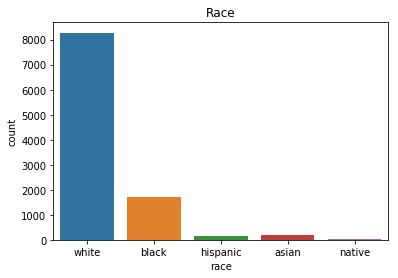

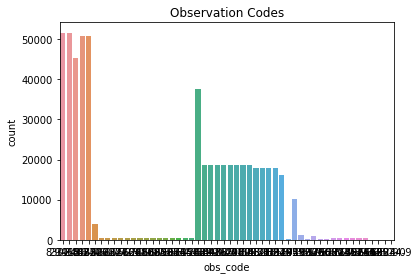

In [10]:
# Look at the categorical variables

sns.countplot(x='race', data=patients)
plt.title('Race')
plt.show()

sns.countplot(x='obs_code',data=observations)
plt.title('Observation Codes')
plt.show()

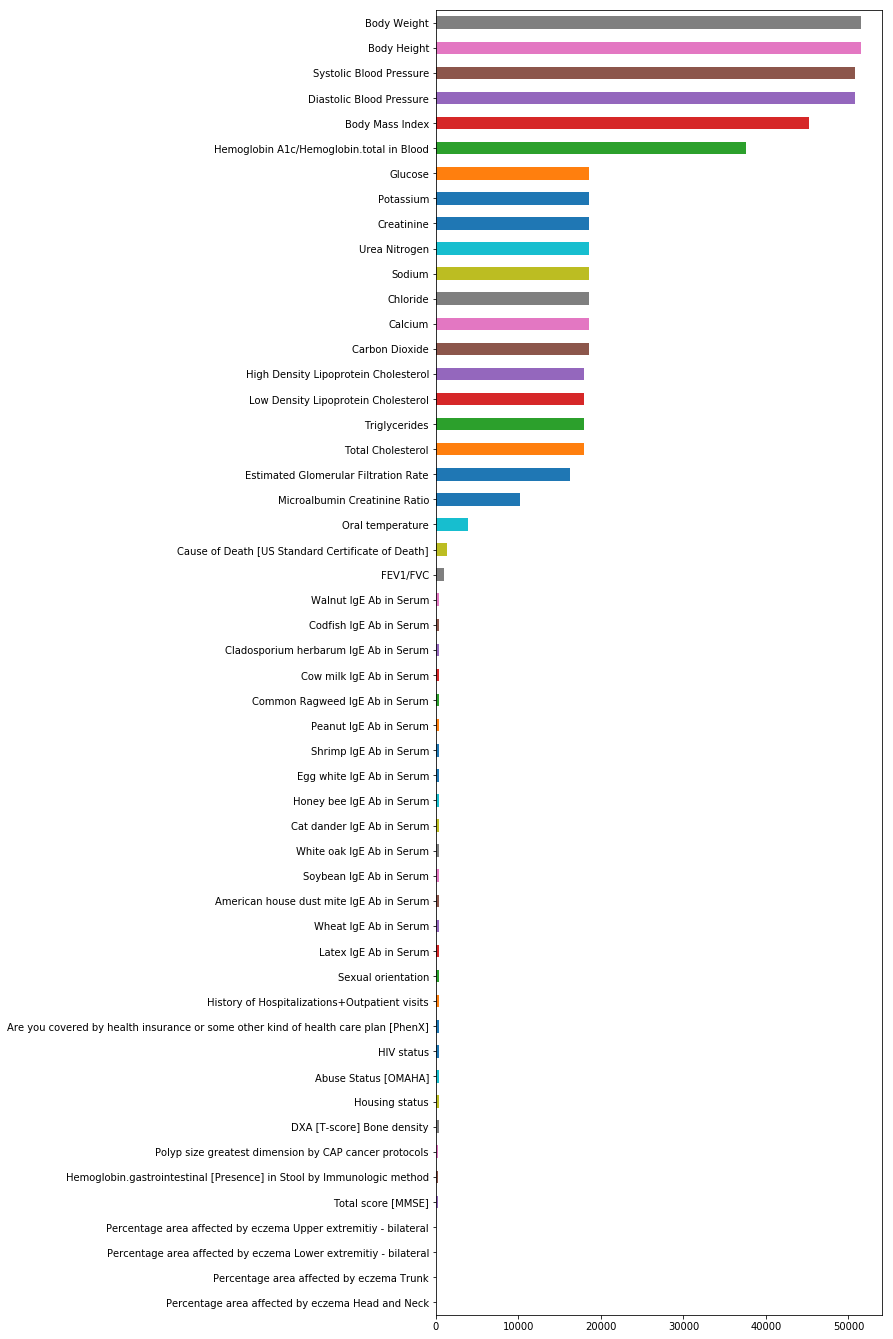

In [11]:
# The observations are hard to read, lets try a bar plot
c = observations['obs_description'].value_counts(ascending=True)
fig = plt.figure(figsize=(8,24))
c.plot(kind="barh")

### 3.3 Continuous Variables

In [12]:
# We can get statistics for the continuous variables using the .describe() function
patients.describe()

,pat_id,birth_date,death_date,ssn,drivers,passport,prefix,first,last,suffix,maiden,marital,race,ethnicity,gender,birthplace,address,prior_opioid_abuse_diag
count,10368,10368,10368,10368,10368,10368,10368,10368,10368,10368,10368,10368,10368,10368,10368,10368,10368,10368
unique,10368,8813,1267,10302,7745,7435,4,4049,888,4,625,3,5,23,2,909,10368,2
top,d96d4358-364a-4039-9dd0-f34b6cb61639,1960-09-09,,999-30-2602,,,Mr.,Hugo693,Adams676,,,M,white,irish,F,Columbus,766 Nikolaus Haven Suite 33 Elyria Ohio 44035 US,0
freq,1,5,9032,3,2306,2934,3726,15,34,10316,7749,5073,8276,2108,5330,1074,1,7020


Average weight:  72.22758018510936


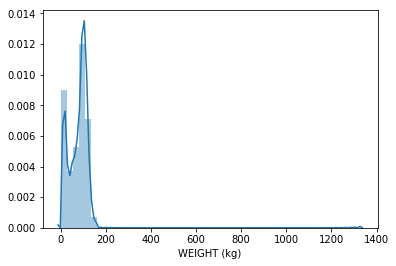

In [13]:
# For continuous variables, we can graph the distribution

w = observations[observations['obs_code']=='29463-7']   # Find all of the "weight" observations
weights = w['obs_value'].astype(np.float).dropna()
mean = np.mean(weights)
print('Average weight: ',mean)

# Plot the distribution
sns.distplot(weights)
plt.xlabel("WEIGHT (kg)")
plt.show()   # If you don't explicitly "show" the plot, Jupyter will automatically show the last plot

In [14]:
# As an Exercise, graph the Height of patients

# Height LOINC code is 8302-2



# 4.0 Data Preparation

Now that we know a little about our data, we can begin to prepare it for analysis.  We need to:
1. Find data that is not formatted correctly
2. Deal with missing data

In all of these cases, we will have to decide what to do with the bad data.  We can:
1. Delete the data
2. Impute a reasonable value for the missing data

### 4.1 Data Quality Checks

Start by running a few data quality checks against all of the data.  For this workshop, we will only look at missing data or incorrectly formatted data but with a real data science project you would also want to check that the relationships between all of the data elements makes sense.  For example, you'd ensure that the `birth_date` is less than today.

The functions below attempt to convert the data (which we read in as simple strings) to the data format that we defined for each variable.  That's how we will tell if it is in the correct format.

In [15]:
# Find data that is not formatted correctly

def parse_date(dt,fmt):
    if type(dt) == str and (dt == ''):
        return dt
    try:
        return pd.to_datetime(dt,format=fmt)
    except:
        return np.datetime64('NaT')

def parse_int(num):
    if type(num) == str and (num == ''):
        return num
    try:
        return int(num)
    except:
        return np.nan

# Loop through our Data Dictionary
for name, tbl_dd in dd.items():
    display(HTML('<h2>{}</h2>'.format(name)))
    d = data[name]
    for field_name, field in tbl_dd.items():
        col = d[field_name]
        field['DQ'] = {}
        field['DQ']['missing'] = len(np.where(col == '')[0])

        if field['type'] == np.datetime64:
            if 'format' in field:
                fmt = field['format']
            else:
                fmt = '%Y-%m-%d'   # Default date format if not specified
                
            d[field_name] = col.apply(lambda x: parse_date(x,fmt))
            field['DQ']['format_errors'] = col.isnull().sum()
        elif field['type'] == np.int:
            d[field_name] = col.apply(lambda x: parse_int(x))
            field['DQ']['format_errors'] = col.isnull().sum()
        elif field['type'] == np.str:
            pass # Everything is valid syntax
            field['DQ']['format_errors'] = 0
            
    # Show the Data Quality information
    display(pd.DataFrame(dd[name]))
    


,address,birth_date,birthplace,death_date,drivers,ethnicity,first,gender,last,maiden,marital,passport,pat_id,prefix,prior_opioid_abuse_diag,race,ssn,suffix
DQ,"{'missing': 0, 'format_errors': 0}","{'missing': 3, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 9032, 'format_errors': 2}","{'missing': 2306, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 7749, 'format_errors': 0}","{'missing': 3940, 'format_errors': 0}","{'missing': 2934, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 2641, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 10316, 'format_errors': 0}"
format,NaN,%Y-%m-%d,NaN,%Y-%m-%d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
required,True,True,NaN,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN
type,<class 'str'>,<class 'numpy.datetime64'>,<class 'str'>,<class 'numpy.datetime64'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>


,enc_code,enc_date,enc_description,enc_id,enc_pat_id,enc_reason_code,enc_reason_description
DQ,"{'missing': 0, 'format_errors': 0}","{'missing': 3, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 93059, 'format_errors': 0}","{'missing': 93059, 'format_errors': 0}"
format,NaN,%Y-%m-%d,NaN,NaN,NaN,NaN,NaN
required,True,True,True,True,True,NaN,NaN
type,<class 'str'>,<class 'numpy.datetime64'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>


,obs_code,obs_date,obs_description,obs_enc_id,obs_pat_id,obs_units,obs_value
DQ,"{'missing': 0, 'format_errors': 0}","{'missing': 5, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}"
format,NaN,%Y-%m-%d,NaN,NaN,NaN,NaN,NaN
required,True,True,True,True,True,NaN,NaN
type,<class 'str'>,<class 'numpy.datetime64'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>


,med_code,med_days_supply,med_description,med_enc_id,med_pat_id,med_reason_code,med_reason_description,med_start_date,med_stop_date
DQ,"{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 13130, 'format_errors': 0}","{'missing': 13130, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 3376, 'format_errors': 0}"
format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,%Y-%m-%d,%Y-%m-%d
required,True,NaN,True,True,True,NaN,NaN,True,False
type,<class 'str'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'numpy.datetime64'>,<class 'numpy.datetime64'>


,cond_code,cond_description,cond_enc_id,cond_pat_id,cond_start_date,cond_stop_date
DQ,"{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 4349, 'format_errors': 0}"
format,NaN,NaN,NaN,NaN,%Y-%m-%d,%Y-%m-%d
required,True,True,True,True,True,False
type,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'numpy.datetime64'>,<class 'numpy.datetime64'>


### 4.2 Drop unwanted columns

In [16]:
# Let's remove some of the data that we won't need to use for the workshop
# It will make some of the screens easier to read
# Put it in a try block in case we've already dropped the columns
try:
    patients.drop(['maiden','passport','drivers','prefix','suffix','ssn','first','last'],axis=1,inplace=True)
except:
    pass
display(patients.head(1))

,pat_id,birth_date,death_date,marital,race,ethnicity,gender,birthplace,address,prior_opioid_abuse_diag
0,52e3f2e9-82a1-4ec5-b90a-e42c17551da8,2009-05-16,,,white,portuguese,F,Columbus,278 Green Pathway Ashland Ohio 44805 US,0


### 4.3 Remove rows with missing data

For this workshop, we will only deal with missing data by dropping it.  If a row has missing or bad formatted data and the field is required, we will drop the entire row.

An alternative is to try to fix the data by imputing a reasonable value for it, such as the column .mean().

In [17]:
# The .isnull() functions are used to find bad data
# The .any() function returns the columns that contain any True values

display(patients.isnull().head(5))
display(patients.isnull().any())

# Let's get a list of all of the columns with some missing data 
missing_cols=patients.columns[patients.isnull().any()]
print(missing_cols)

# We can see how many cells have missing data for each column
patients[missing_cols].isnull().sum()


,pat_id,birth_date,death_date,marital,race,ethnicity,gender,birthplace,address,prior_opioid_abuse_diag
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False


pat_id                     False
birth_date                  True
death_date                  True
marital                    False
race                       False
ethnicity                  False
gender                     False
birthplace                 False
address                    False
prior_opioid_abuse_diag    False
dtype: bool

Index(['birth_date', 'death_date'], dtype='object')


birth_date    7
death_date    2
dtype: int64

In [18]:
# Drop missing or incorrectly formatted data for the required patient data fields

# Get the row numbers (index) of each of the rows with missing data
missing = patients[patients.isnull().any(axis=1)].index
print("Missing = ",missing)
print('Before patients shape = ',patients.shape)
patients.drop(missing,inplace=True)

# Make sure the rows are gone
missing = patients[patients.isnull().any(axis=1)].index
print("Missing = ",missing)
print('After patients shape = ',patients.shape)



Missing =  Int64Index([176, 1094, 4229, 5116, 5440, 5700, 5782, 7676, 8077], dtype='int64')
Before patients shape =  (10368, 10)
Missing =  Int64Index([], dtype='int64')
After patients shape =  (10359, 10)


### 4.4 Transform the Data

Use the power of Pandas Dataframes to transform the data.  Add new columns as calculations from existing columns, join the data together and get it into the format you need for analysis.



In [19]:
# Create the working dataframe

df = patients
df['age'] = round((pd.Timestamp.today() - pd.to_datetime(patients['birth_date'])).dt.days/365)
df['adult'] = np.where(df['age'] >= 18, 1, 0)

# Determine which patients have ever overdosed
# Use a set to eliminate duplicates
patients_that_overdosed = set(encounters[encounters['enc_reason_code']=='55680006']['enc_pat_id'])  # Overdose
df['overdose'] = np.where(df['pat_id'].isin(patients_that_overdosed), 1, 0)

# Determine which patients were ever prescribed opioids
patients_prescribed_opioids = set(medications[medications['med_code'].isin(opioids_rxnorm)]['med_pat_id'])  # Opioids
df['prescribed_opioids'] = np.where(df['pat_id'].isin(patients_prescribed_opioids), 1, 0)

print('Num patients prescribed opioids = {}, Num overdoses = {}'
         .format(len(patients_prescribed_opioids),len(patients_that_overdosed)))

Num patients prescribed opioids = 1181, Num overdoses = 405


In [20]:
# Determine which patients have died from an overdose
# Uses binary indexing
obs = observations[(observations['obs_code'] == '69453-9') &   # Death
                                (observations['obs_value'].str.contains('overdose'))]
print('Example of an overdose death observation:')
display(pd.DataFrame(obs.iloc[0,:]))
patients_overdose_deaths = set(obs['obs_pat_id'])
print('Number of overdose deaths = {}'.format(len(patients_overdose_deaths)))
print('Here are the overdose deaths:')
display(df[df['pat_id'].isin(patients_overdose_deaths)])

Example of an overdose death observation:


,2903
obs_date,2013-03-06 00:00:00
obs_pat_id,9d921a72-2210-4f99-bd19-6571cc561bf2
obs_enc_id,b4753545-215e-45a6-9ecc-b8b23a8ec2c1
obs_code,69453-9
obs_description,Cause of Death [US Standard Certificate of Death]
obs_value,Drug overdose
obs_units,null


Number of overdose deaths = 23
Here are the overdose deaths:


,pat_id,birth_date,death_date,marital,race,ethnicity,gender,birthplace,address,prior_opioid_abuse_diag,age,adult,overdose,prescribed_opioids
52,9d921a72-2210-4f99-bd19-6571cc561bf2,1957-02-13,2013-02-27 00:00:00,S,hispanic,mexican,M,Toledo,829 Lubowitz Rue Middleburg Heights Ohio 44017 US,1,61.0,1,1,0
1045,c0147e5e-2daf-4188-b661-2b166d353d14,1979-04-18,1999-10-12 00:00:00,,white,irish,M,Columbus,1001 Monahan Road Austintownship Ohio US,1,39.0,1,1,1
1241,ce316ef4-84b0-4581-9e67-3f5bf4f6106c,1974-08-12,1999-10-17 00:00:00,,black,west_indian,F,Miamisburg,639 O'Connell Neck Apt 20 Willowick Ohio 44092 US,1,44.0,1,1,0
1905,1f0f8eca-1e82-4575-b989-f7e3f31bcf78,1976-10-13,2018-02-08 00:00:00,M,white,english,F,Coshocton,604 Cronin Boulevard Springboro Ohio 45005 US,1,42.0,1,1,0
2917,4c1ee178-7f83-4d6d-b005-a51eb3735942,1976-01-14,2013-08-31 00:00:00,S,white,italian,F,Miamiship,898 Wisoky Bypass Cleveland Ohio 44101 US,1,42.0,1,1,1
3591,d26f7b19-667a-4074-abf0-172eaa172c59,1975-09-08,2016-10-15 00:00:00,M,white,italian,M,Columbus,1017 Walsh Pathway Columbus Ohio 43002 US,1,43.0,1,1,1
3756,0906ce70-e760-45cb-af8b-e06a1b12c2b6,1979-03-26,2009-08-11 00:00:00,S,white,irish,M,Cleveland,947 Block Parade Suite 76 Pleasantship Ohio US,1,39.0,1,1,1
3948,88c8a08d-074b-4976-aa65-97aabb91f42f,1948-11-20,2012-01-23 00:00:00,S,white,italian,F,Cleveland,531 Powlowski Haven Amherst Ohio 44001 US,1,70.0,1,1,0
4686,90ea8ac6-2b60-4975-abfc-466d00a50b43,1975-09-21,2006-08-09 00:00:00,M,white,german,F,Dayton,194 Hand Tunnel Apt 74 Akron Ohio 44203 US,1,43.0,1,1,1
4941,02ed4e95-d719-413d-9c6b-2166654913c6,1985-12-27,2007-07-24 00:00:00,,white,english,F,Columbus,592 Grimes Bay Columbus Ohio 43002 US,0,32.0,1,1,0


### 4.5 Compute the days_supply variable

We want to compute how many days supply of a medication a patient was prescribed at discharge.  The approach we will use is that for each encounter, we will find all of the medications associated with the encounter.  We will look for medicates that are opioids and find the largest days supply for that encounter and store the result in the 'opioid_discharge_days_supply' column.

This is most easily accomlished using a function that defines the logic and the ".apply" DataFrame function the will iterate over each row in a DataFrame, call the function and store the result back in the DataFrame.

In [21]:
# Define the function that will perform to logic of compute the discharge opioid days supply

def get_days_supply(pat_id):
    enc_meds = medications[medications['med_pat_id'] == pat_id]
    enc_opioid_meds = enc_meds[enc_meds['med_code'].isin(opioids_rxnorm)]
    max = 0
    if len(enc_opioid_meds) > 0:
        try:
            max = int(enc_opioid_meds['med_days_supply'].max())
        except ValueError:
            max = 0
    return int(max)

# Apply the function to each row (Note: this can take a little while to finish)
df['opioid_discharge_days_supply'] = df.apply(lambda x: get_days_supply(x['pat_id']), axis=1)

# Display the first 5 entries that have a non-zero days supply, just to check our logic
df[df['opioid_discharge_days_supply'] > 0].head(5)

,pat_id,birth_date,death_date,marital,race,ethnicity,gender,birthplace,address,prior_opioid_abuse_diag,age,adult,overdose,prescribed_opioids,opioid_discharge_days_supply
29,5a9fbf3d-9907-4f99-a552-96db348d845d,1974-03-13,,M,black,african,M,Bellevue,935 Hoeger Ville West Carrollton Ohio 45342 US,1,44.0,1,1,1,29
47,e1505eef-a5bc-419d-a9ff-2776de88caff,1953-08-15,,S,white,italian,F,Mason,396 Dibbert Byway Cincinnati Ohio 45202 US,0,65.0,1,1,1,27
49,cbcd4a47-a60b-43d7-8c49-f58b2620988b,1955-05-28,,M,white,irish,F,Ottawa village,717 Gutmann Gate Suite 79 Columbus Ohio 43002 US,1,63.0,1,1,1,28
55,f1f9d9e5-4d2b-40e1-b944-977dd9d83741,1985-07-19,,M,white,english,F,Shaker Heights,1086 Herzog Mews Apt 95 Fremont Ohio 43420 US,0,33.0,1,0,1,4
60,b8465dea-d0f2-46a0-aa9d-bce07cee8a35,1962-11-28,,M,white,french,M,Cleveland Heights,217 Sawayn Trafficway Miamiship Ohio US,0,56.0,1,0,1,2


In [23]:
# Write the pickled data 
df.to_pickle(datadir+'/data_cleaned_oh.pkl')

# 5.0 Explore the Data - Part 2

### 5.1 Outcome variable

Now that we have created some new variables, lets take a look at how the outcome variable is associated with our predictors.

In [24]:
# See who overdosed from prescribed opioids by computing the intersection

overlap = patients_that_overdosed.intersection(patients_prescribed_opioids)

print('Num that overdose = {}, Num that were prescribed opioids = {}, overlap = {}'.format(\
    len(patients_that_overdosed),len(patients_prescribed_opioids),len(overlap)))


Num that overdose = 405, Num that were prescribed opioids = 1181, overlap = 249


How many patients overdosed?

Since we store 'overdose' as a 0 or 1, we can just use the mean function to compute what percent of the population overdosed


In [25]:
overdose = df[df['pat_id'].isin(patients_prescribed_opioids)]
display(overdose['overdose'].value_counts())
print('Percent that overdosed: {0:.2f}%'.format(overdose['overdose'].mean()*100))

0    932
1    249
Name: overdose, dtype: int64

Percent that overdosed: 21.08%


### 5.2 Crosstabs

opioid_discharge_days_supply,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
prescribed_opioids,,,,,,,,,,,,,,,,,,,,,
0,9178,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,13,195,206,197,216,24,17,13,10,...,28,30,26,27,22,18,30,27,30,17


Text(0.5,1,'Days Supply for Opioid Patients')

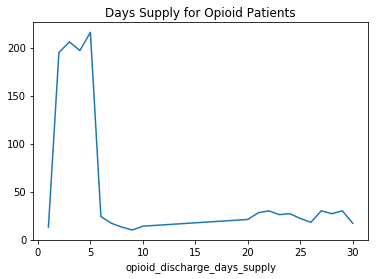

In [26]:
# What was the mean number of days_supply for patients that overdosed and were prescribed opioids?

ct = pd.crosstab(df['prescribed_opioids'],df['opioid_discharge_days_supply'])
display(ct)
ct.iloc[1][1:].plot()
plt.title('Days Supply for Opioid Patients')


### 5.3 Graph the patient variables against the outcome

Let's see if gender, race and age are associated with the outcome

Text(0,0.5,'Count')

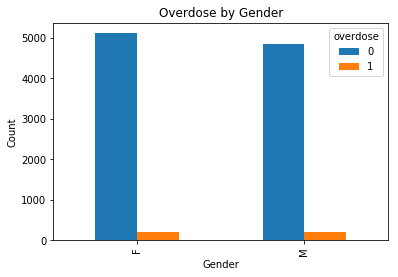

In [27]:
pd.crosstab(patients['gender'],patients['overdose']).plot(kind='bar')
plt.title('Overdose by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

Text(0,0.5,'Count')

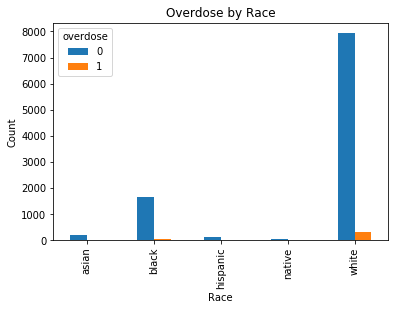

In [28]:
pd.crosstab(patients['race'],patients['overdose']).plot(kind='bar')
plt.title('Overdose by Race')
plt.xlabel('Race')
plt.ylabel('Count')

We have a pretty uniform distribution of ages in the patient data

Text(0,0.5,'Frequency')

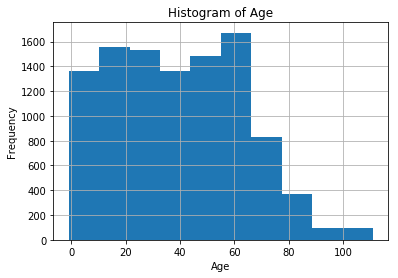

In [29]:
# Histograms are easy to create
patients['age'].hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

### 5.4 Grouping by a variable

We often want to group related rows together and then count the number rows of each type or find the mean of a variable for each row type.

For example, lets count how many encounters each patient has over the timeframe of the data.  We will use the `groupby` function to group on a set of variables.  The operation returns a `groupby` object which doesn't actually group the data but instead acts like a set of instructions telling the DataFrame how to group itself.  We need to apply another function, such as size(), mean() or sum(), to the groups to yield a result.

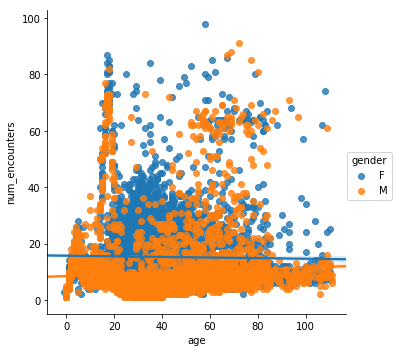

In [30]:
# How many encounters does each patient have?

encs = encounters.groupby(['enc_pat_id']).size()

# We can store that information directly into the patients DataFrame since `encs` is indexed by the pat_id
patients = patients.set_index('pat_id')
patients['num_encounters'] = encs
patients = patients.reset_index()

# Visualize the number of encounters as a patient ages, use color to highlight the gender difference
sns.lmplot(data=patients,x='age',y='num_encounters',hue='gender')

In [31]:
# We can also apply a function to the groups
df.groupby('overdose').mean()


,prior_opioid_abuse_diag,age,adult,prescribed_opioids,opioid_discharge_days_supply
overdose,,,,,
0,0.306409,38.827908,0.764316,0.093631,0.626683
1,0.733333,52.335802,0.997531,0.614815,10.187654


### 5.5 For those that overdose, what is the days_supply?

In [32]:
display(df[df['overdose']==1].mean())
df[df['prescribed_opioids']==1].mean()

prior_opioid_abuse_diag          0.733333
age                             52.335802
adult                            0.997531
overdose                         1.000000
prescribed_opioids               0.614815
opioid_discharge_days_supply    10.187654
dtype: float64

prior_opioid_abuse_diag          0.413209
age                             48.336156
adult                            0.917866
overdose                         0.210838
prescribed_opioids               1.000000
opioid_discharge_days_supply     8.775614
dtype: float64

### 5.6 What are the primary reasons for visit for patients that ever overdosed?

In [33]:
encounters[encounters['enc_pat_id'].isin(patients_that_overdosed)]['enc_reason_description'].value_counts(sort=True)

                                                            8791
Drug overdose                                                790
Normal pregnancy                                             651
Viral sinusitis (disorder)                                   225
Acute viral pharyngitis (disorder)                           107
Acute bronchitis (disorder)                                   98
Sinusitis (disorder)                                          38
Malignant tumor of colon                                      27
Streptococcal sore throat (disorder)                          24
Asthma                                                        18
Overlapping malignant neoplasm of colon                       17
Acute bacterial sinusitis (disorder)                          16
Concussion with no loss of consciousness                      11
Injury of tendon of the rotator cuff of shoulder              10
Escherichia coli urinary tract infection                      10
Alzheimer's disease (diso

### 5.7 Who overdosed?

In [34]:
# Who were the patients that overdosed?

pt = df[df['pat_id'].isin(patients_that_overdosed)]

pt.head(5)


,pat_id,birth_date,death_date,marital,race,ethnicity,gender,birthplace,address,prior_opioid_abuse_diag,age,adult,overdose,prescribed_opioids,opioid_discharge_days_supply
18,cb826f5d-d818-4f57-b422-4898aaa31391,1987-12-23,,M,white,irish,M,Cleveland,372 Rippin Rapid Keeneship Ohio US,1,30.0,1,1,0,0
27,a35b0040-9af5-4aae-90f0-2956f0d8cb84,1979-08-18,,M,white,italian,F,Toledo,570 Weber Lodge Apt 43 Coshocton Ohio 43812 US,1,39.0,1,1,0,0
29,5a9fbf3d-9907-4f99-a552-96db348d845d,1974-03-13,,M,black,african,M,Bellevue,935 Hoeger Ville West Carrollton Ohio 45342 US,1,44.0,1,1,1,29
47,e1505eef-a5bc-419d-a9ff-2776de88caff,1953-08-15,,S,white,italian,F,Mason,396 Dibbert Byway Cincinnati Ohio 45202 US,0,65.0,1,1,1,27
49,cbcd4a47-a60b-43d7-8c49-f58b2620988b,1955-05-28,,M,white,irish,F,Ottawa village,717 Gutmann Gate Suite 79 Columbus Ohio 43002 US,1,63.0,1,1,1,28


### 5.8 Get an idea of how a patient progresses through their healthcare

When exploring the data, it helps to visualize what is happening across time.  You can create small functions within the Jupyter notebook and reuse them further down in the notebook.  

In this case, we are looping through the encounter data for a patient and print all of the medications and labs (observations) that are associated with the patient.  The function `display_trajectory` is passed the id for a patient and then prints the information.  We can use this later to further examine data or debug things we don't understand.

In [35]:
def display_trajectory(df,pt_id):
    pt = patients[patients['pat_id']==pt_id]

    display(pt)
    encs = encounters[encounters.enc_pat_id == pt_id]
    #print(encs.shape)
    for i, e in encs.iterrows():
        #dt = df[df['pat_id']==e['enc_pat_id']].iloc[0]
        print('  {:%Y-%m-%d}: {} ({}) ({})'.format(e['enc_date'], e['enc_description'], \
                         e['enc_code'], e['enc_reason_description']))
        meds = medications[medications['med_enc_id'] == e['enc_id']]
        for j, m in meds.iterrows():
            print('     MED: {:%Y-%m-%d}: {} ({}) days_supply={}'.format(m['med_start_date'],  \
                                            m['med_description'], m['med_code'], m['med_days_supply']))
        labs = observations[observations['obs_enc_id'] == e['enc_id']]
        for k, l in labs.iterrows():
            print('     LAB: {:%Y-%m-%d %H:%M}: {} ({}) {} {}'.format(l['obs_date'], l['obs_description'], l['obs_code'], l['obs_value'], l['obs_units']))
            
            

In [36]:
# Display the trajectory of one of the overdose patients
pt_id = list(patients_that_overdosed)[1]
display_trajectory(df,pt_id)

,pat_id,birth_date,death_date,marital,race,ethnicity,gender,birthplace,address,prior_opioid_abuse_diag,age,adult,overdose,prescribed_opioids,opioid_discharge_days_supply,num_encounters
736,b76e4dcb-0236-45a1-b4bc-59f1adec0f39,1963-07-21,2002-07-14 00:00:00,M,white,english,M,Toledo,719 Rolfson Track Apt 17 Perkinsship Ohio US,1,55.0,1,1,1,29,38


  1997-10-05: Encounter for check up (procedure) (185349003) ()
     MED: 1997-10-05: oxyCODONE Hydrochloride 15 MG [OxyCONTIN] (1049544) days_supply=29
     LAB: 1997-10-05 00:00: Body Height (8302-2) 175.7 cm
     LAB: 1997-10-05 00:00: Body Weight (29463-7) 109.0 kg
     LAB: 1997-10-05 00:00: Body Mass Index (39156-5) 35.3 kg/m2
     LAB: 1997-10-05 00:00: Diastolic Blood Pressure (8462-4) 87.8 mmHg
     LAB: 1997-10-05 00:00: Systolic Blood Pressure (8480-6) 119.6 mmHg
     LAB: 1997-10-05 00:00: Total Cholesterol (2093-3) 186.0 mg/dL
     LAB: 1997-10-05 00:00: Triglycerides (2571-8) 139.9 mg/dL
     LAB: 1997-10-05 00:00: Low Density Lipoprotein Cholesterol (18262-6) 93.6 mg/dL
     LAB: 1997-10-05 00:00: High Density Lipoprotein Cholesterol (2085-9) 64.5 mg/dL
  1997-10-04: Emergency Room Admission (50849002) (Drug overdose)
  1997-11-08: Drug addiction therapy (266707007) ()
  1997-12-08: Drug addiction therapy (266707007) ()
  1998-01-07: Drug addiction therapy (266707007) ()

# 6.0 Modeling

We will be using the `scikit-learn` package, which is an open-source library that provides a robust set of machine learning algorithms for Python. It is built upon the core Python scientific stack and has a simple, consistent interface.

<img src="http://1.bp.blogspot.com/-ME24ePzpzIM/UQLWTwurfXI/AAAAAAAAANw/W3EETIroA80/s1600/drop_shadows_background.png" width="800px"/>



### 6.1 Load scikit-learn libraries

In [37]:
# Load the modules
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
import random as rnd
from random import random, randint

### 6.2 Encode categorical variables

Most of the models in scikit-learn require the categorical variables be turned into numeric variables.  There are two approaches to this:
1. One Hot Encoding - each item in the categorical variable is turned into its own variable represetnting the presence or abscence of that item.  For example, 'Gender' would turn into 2 variables:  'Gender_M' and 'Gender_F'
2. Label Encoding - assign an integer to each item.  For the 'Gender' variable, 0 might mean Male and 1 might mean Female.

We will use the `LabelEncoder` transformation to change categorical variables into integers.  As a convenience, we can also keep the original (human readable) variable in the Dataframe.

In [38]:
# Let's use the following variables as our initial set of predictors
cat_cols = ['gender', 'marital', 'race', 'ethnicity']
cat_cols_encoded = [c + '_encoded' for c in cat_cols]
numeric_cols = ['prior_opioid_abuse_diag', 'age', 'opioid_discharge_days_supply']
pred_cols = numeric_cols + cat_cols_encoded
target_col = 'overdose'
all_cols = cat_cols+numeric_cols+[target_col]

df_opioids = df[df['prescribed_opioids'] == 1]

# Encode the categorical variables
dfe = df_opioids[cat_cols]

# Replace missing data with an 'Unknown' category so the missing data will also be encoded
dfe = dfe.replace(np.NaN,'Unknown')

# Encode the categorical variables
encoded = dfe.apply(preprocessing.LabelEncoder().fit_transform)

# Append the non-categorical variables and the encoded variables into a single Dataframe
# Name the new variables as <name>_encoded
dfe = pd.concat([df_opioids[all_cols], encoded.add_suffix('_encoded')],axis=1)
display(dfe.head(2))

,gender,marital,race,ethnicity,prior_opioid_abuse_diag,age,opioid_discharge_days_supply,overdose,gender_encoded,marital_encoded,race_encoded,ethnicity_encoded
29,M,M,black,african,1,44.0,29,1,1,1,1,0
47,F,S,white,italian,0,65.0,27,1,0,2,4,13


### 6.3 Identify potential predictor variables

In [39]:
# Let's see which variables are correlated with the outcome variable
display(dfe.corr())

,prior_opioid_abuse_diag,age,opioid_discharge_days_supply,overdose,gender_encoded,marital_encoded,race_encoded,ethnicity_encoded
prior_opioid_abuse_diag,1.000000,0.037177,0.156694,0.316642,-0.027493,0.081174,-0.013502,0.010596
age,0.037177,1.000000,-0.050267,0.105570,0.020507,0.562451,-0.021644,-0.042109
opioid_discharge_days_supply,0.156694,-0.050267,1.000000,0.439939,-0.015768,0.005930,0.008963,0.040754
overdose,0.316642,0.105570,0.439939,1.000000,-0.006467,0.170757,0.025277,0.043649
gender_encoded,-0.027493,0.020507,-0.015768,-0.006467,1.000000,0.009360,-0.019682,0.001306
marital_encoded,0.081174,0.562451,0.005930,0.170757,0.009360,1.000000,-0.013662,-0.028939
race_encoded,-0.013502,-0.021644,0.008963,0.025277,-0.019682,-0.013662,1.000000,0.229008
ethnicity_encoded,0.010596,-0.042109,0.040754,0.043649,0.001306,-0.028939,0.229008,1.000000


In [40]:
# Lets try to build a model using this set of variables
pred_cols = ['age', 'opioid_discharge_days_supply', 
             'prior_opioid_abuse_diag', \
             'gender_encoded', 'marital_encoded', 'race_encoded', 'ethnicity_encoded']
#pred_cols = ['prior_abuse_diag', 'adult', 'age_at_visit', 'opioid_discharge_days_supply', \
#             'gender_encoded', 'marital_encoded', 'race_encoded', 'ethnicity_encoded']

LR_pred_cols = pred_cols
X = dfe[pred_cols].as_matrix()
y = dfe['overdose'].as_matrix()
print('Using predictor variables of:',pred_cols)

Using predictor variables of: ['age', 'opioid_discharge_days_supply', 'prior_opioid_abuse_diag', 'gender_encoded', 'marital_encoded', 'race_encoded', 'ethnicity_encoded']


### 6.4 Confusion matrix
Jupyter notebooks can embed any type of information in Markdown including images, videos and linnks to resources.  

To remind us of the definitions of recall (sensitivity) and precision (positive predictive value), here is a graphic from Wikipedia:

![Confusion Matrix](Sensitivity-Wikipedia.png)

To quote from Scikit Learn:

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

Accuracy is (tp + tn) / N.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important.

The support is the number of occurrences of each class in y_test.

### 6.5 Logistic Regression

In [41]:
# Let's try a simple logistic regression model to see how predictive our data is

LR = LogisticRegression()
result = LR.fit(X,y)

expected = y
predicted = LR.predict(X)

print('\nClassification Report\n',metrics.classification_report(expected, predicted))
print('\nConfusion Matrix\n',metrics.confusion_matrix(expected, predicted))
print('\nAccuracy score =',metrics.accuracy_score(expected, predicted))
print('\nAUC score =',metrics.roc_auc_score(expected, predicted))
print('\nf1 score =',metrics.f1_score(expected, predicted))




Classification Report
              precision    recall  f1-score   support

          0       0.86      0.95      0.91       932
          1       0.71      0.43      0.54       249

avg / total       0.83      0.84      0.83      1181


Confusion Matrix
 [[887  45]
 [141 108]]

Accuracy score = 0.842506350550381

AUC score = 0.6927258389782306

f1 score = 0.537313432835821


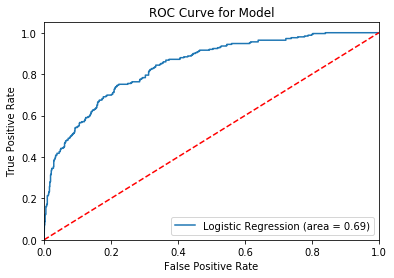

In [42]:
# Lets graph an ROC curve for the model

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
auc = roc_auc_score(y, LR.predict(X))

probs = LR.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, probs)
tpr[1] = tpr[0]

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Model')
plt.legend(loc="lower right")
plt.savefig('ROC1.png')


# 7.0 Model Evaluation

We built a Logistic Regression model that was predictive of overdose risk.  But we trained the model and tested it with our entire data set, which isn't exactly a fair test of the model.

We should split our dataset into a training dataset and a test dataset.  After we train the model using just the training dataset, we will evaluate the model using the test dataset which has data that the model has never seen before.

scikit-learn has a helpful function called `train_test_split` that randomly splits our dataset.


In [43]:
# Create the training and test datasets
train, test = train_test_split(dfe, test_size=0.3, random_state=987)

X_train = train[pred_cols].as_matrix()
y_train = train['overdose'].as_matrix()
X_test = test[pred_cols].as_matrix()
y_test = test['overdose'].as_matrix()

print('X_train shape = ',X_train.shape)
print('y_train shape = ',y_train.shape)
print('X_test shape = ',X_test.shape)
print('y_test shape = ',y_test.shape)

X_train shape =  (826, 7)
y_train shape =  (826,)
X_test shape =  (355, 7)
y_test shape =  (355,)


### 7.1 Logistic Regression

In [44]:
LR = LogisticRegression()
result = LR.fit(X_train,y_train)
print(LR)
expected = y_train
predicted = LR.predict(X_train)
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

expected = y_test
predicted = LR.predict(X_test)

print('\nClassification Report\n',metrics.classification_report(expected, predicted))
print('\nConfusion Matrix\n',metrics.confusion_matrix(expected, predicted))
print('\nAccuracy score =',metrics.accuracy_score(expected, predicted))
print('\nAUC score =',metrics.roc_auc_score(expected, predicted))
print('\nf1 score =',metrics.f1_score(expected, predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.88      0.95      0.91       664
          1       0.71      0.45      0.55       162

avg / total       0.84      0.86      0.84       826

[[634  30]
 [ 89  73]]

Classification Report
              precision    recall  f1-score   support

          0       0.83      0.94      0.88       268
          1       0.69      0.40      0.51        87

avg / total       0.79      0.81      0.79       355


Confusion Matrix
 [[252  16]
 [ 52  35]]

Accuracy score = 0.8084507042253521

AUC score = 0.6712986790186997

f1 score = 0.5072463768115941


### 7.2 Graph an ROC curve

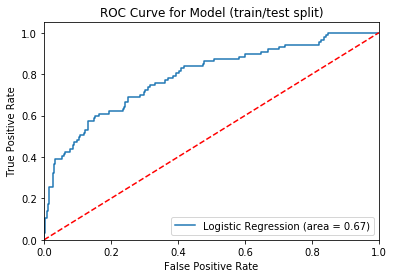

In [45]:
# Lets graph an ROC curve for the model

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
auc = roc_auc_score(y_test, LR.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, LR.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Model (train/test split)')
plt.legend(loc="lower right")
plt.savefig('ROC2.png')

### 7.3 Cross Validation

Splitting the data into a training dataset and a test dataset has a drawback in that it doesn't allow us to train the model on all of the data.  Another approach is to use k-fold cross validation where we randomly divide the data into k equal sized subsets and then train the model on the remaining k-1 segments of the data and test it on the data that we held out.  The process is repeated k times so that in the end all of the data is used at some point to train the model.  The k model results are averaged to produce a single estimate of model performance.

In [46]:
kfold = model_selection.KFold(n_splits=10, random_state=387)
results = model_selection.cross_val_score(LR, X_train, y_train, cv=kfold, scoring='roc_auc')

print('Model score = %.4f (%.4f)' %(results.mean(), results.std()))


Model score = 0.8506 (0.0694)


### 7.4 Testing many models

The nice thing about scikit-learn is that most of the models have similar calling signatures so we can just create a list of all of the models we are interested in testing and then invoke each model in a for loop.

We can train each model in turn and then use k-fold cross validate to estimate model performance.

In [47]:
# Cross validation test harness 

# Make this into a function so we can reuse it later

def eval_models(X, y):
    # prepare models
    models = []
    models.append(('LR', LogisticRegression(class_weight='balanced')))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('RF', RandomForestClassifier(n_estimators=100, class_weight='balanced')))
    # evaluate each model in turn
    results = []
    names = []
    #scoring = 'accuracy'
    scoring = 'roc_auc' # others include: 'accuracy', 'f1', 'roc_auc', 
                        # or found here: http://scikit-learn.org/stable/modules/model_evaluation.html
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=543)
        cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return results, names

# Execute the function
results, names = eval_models(X,y)  

LR: 0.836286 (0.030861)
LDA: 0.836135 (0.033648)
KNN: 0.789032 (0.035552)
CART: 0.717782 (0.052805)
NB: 0.849588 (0.024965)
RF: 0.875363 (0.034598)


### 7.5 Graphically viewing model performance using a boxplot

None of the models do very well.  LogisticRegression does the best but most of the models have quite a bit of variance in their scores.


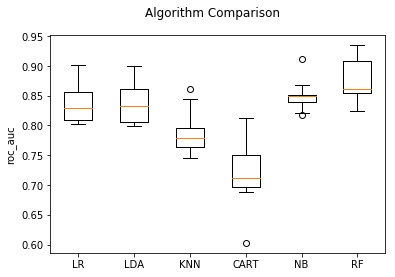

In [48]:
# boxplot algorithm comparison
def plot_perf(names,results):
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    plt.ylabel('roc_auc')
    ax.set_xticklabels(names)
    plt.show()
    
plot_perf(names,results)

### 7.8 Predict the risk for new patients

In [49]:
# Show how to use the resulting model to predict opioid overdose
# age, opioid_discharge_days_supply, prior_opioid_abuse_diag, gender (F), marital (M), race (white), ethnicity (english)
new_patient = [45,10,1,0,1,4,7]

pred = LR.predict(np.asmatrix(new_patient))
if pred[0] == 0:
    print('Patient has no overdose risk.')
elif pred[0] == 1:
    print('Patient has overdose risk.')

Patient has no overdose risk.



# 8.0 Workshop Survey

We hope that you found this workshop useful.  We would like for you to give use feedback to improve the workshop by completing a very short survey that you can access at:

https://docs.google.com/forms/d/e/1FAIpQLSct-waQrz7RhWxawmU1kgf7IwAYyONhwMNpgmGYpGJTpATBdA/viewform
    